## Chempy
we will now introduce the Chempy function which will calculate the chemical evolution of a one-zone open box model

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# loading the default parameters

from Chempy.parameter import ModelParameters
a = ModelParameters()

## Loading all the input
- solar abundances
- SFR
- infall
- initial abundances and inflowing abundances

In [3]:
# Initialising sfr, infall, elements to trace, solar abundances

from Chempy.wrapper import initialise_stuff
basic_solar, basic_sfr, basic_infall = initialise_stuff(a)
elements_to_trace = a.elements_to_trace

## Elemental abundances at start
We need to define the abundances of:
- The ISM at beginning
- The corona gas at beginning
- The cosmic inflow into the corona for all times.
For all we chose primordial here.

In [4]:
# Setting the abundance fractions at the beginning to primordial

from Chempy.infall import INFALL, PRIMORDIAL_INFALL
basic_primordial = PRIMORDIAL_INFALL(list(elements_to_trace),np.copy(basic_solar.table))
basic_primordial.primordial()
basic_primordial.fractions

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.76,  0.24,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

## Initialising the element evolution matrix
We now feed everything into the abundance matrix and check its entries

In [5]:
# Initialising the ISM instance

from Chempy.time_integration import ABUNDANCE_MATRIX
cube = ABUNDANCE_MATRIX(np.copy(basic_sfr.t),np.copy(basic_sfr.sfr),np.copy(basic_infall.infall),list(elements_to_trace),list(basic_primordial.symbols),list(basic_primordial.fractions),float(a.gas_at_start),list(basic_primordial.symbols),list(basic_primordial.fractions),float(a.gas_reservoir_mass_factor),float(a.outflow_feedback_fraction),bool(a.check_processes),float(a.starformation_efficiency),float(a.gas_power), float(a.sfr_factor_for_cosmic_accretion), list(basic_primordial.symbols), list(basic_primordial.fractions))


# All the entries of the ISM instance

print(list(cube.cube.dtype.names))


# Helium at start

print('Primordial ratio of H to He: ',cube.cube['H'][0]/cube.cube['He'][0])
print('Helium over time: ',cube.cube['He'])

['sfr', 'infall', 'time', 'feedback', 'mass_in_remnants', 'stars', 'gas', 'Z', 'alpha', 'sn1a', 'sn2', 'pn', 'bh', 'hn', 'Al', 'Ar', 'B', 'Be', 'C', 'Ca', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ga', 'Ge', 'H', 'He', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'Ne', 'Ni', 'O', 'P', 'S', 'Sc', 'Si', 'Ti', 'V', 'Zn']
('Primordial ratio of H to He: ', 3.1666666666666665)
('Helium over time: ', array([  9.26869415e-05,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00]))


## Time integration
With the advance_one_step method we can evolve the matrix in time, given that we provide the feedback from each steps previous SSP.

In [6]:
# Now we run the time integration

from Chempy.wrapper import SSP_wrap
basic_ssp = SSP_wrap(a)
for i in range(len(basic_sfr.t)-1):
    j = len(basic_sfr.t)-i
    
    # The metallicity needs to be passed for the yields to be calculated as well as the initial elemental abundances

    
    element_fractions = []
    for item in elements_to_trace:
        element_fractions.append(float(np.copy(cube.cube[item][max(i-1,0)]/cube.cube['gas'][max(i-1,0)])))## gas element fractions from one time step before	   
    metallicity = float(cube.cube['Z'][i])
    time_steps = np.copy(basic_sfr.t[:j])
    basic_ssp.calculate_feedback(float(metallicity), list(elements_to_trace), list(element_fractions), np.copy(time_steps))
    cube.advance_one_step(i+1,np.copy(basic_ssp.table),np.copy(basic_ssp.sn2_table),np.copy(basic_ssp.agb_table),np.copy(basic_ssp.sn1a_table))
print(cube.cube['He'])

[  9.26869415e-05   1.40860453e-02   2.46201078e-02   3.22716659e-02
   3.75769269e-02   4.09880689e-02   4.28975911e-02   4.36286864e-02
   4.34475615e-02   4.25757031e-02   4.11957803e-02   3.94498921e-02
   3.74567135e-02   3.53087975e-02   3.30824748e-02   3.08305729e-02
   2.86006517e-02   2.64208026e-02   2.43259121e-02   2.23255178e-02
   2.04333626e-02   1.86576398e-02   1.69950788e-02   1.54481327e-02
   1.40162342e-02   1.26941237e-02   1.14762096e-02   1.03656268e-02]


## Making abundances from element fractions
The cube stores everything in elemental fractions, we use a tool to convert these to abundances scaled to solar:

In [7]:
# Turning the fractions into dex values (normalised to solar [X/H])

from Chempy.making_abundances import mass_fraction_to_abundances
abundances,elements,numbers = mass_fraction_to_abundances(np.copy(cube.cube),np.copy(basic_solar.table))
print(abundances['He'])

[-0.02951008 -0.02944417 -0.02371412 -0.01804385 -0.01281405 -0.00807708
 -0.0036858   0.00039861  0.00418825  0.00773171  0.0110975   0.01425566
  0.01724532  0.02006999  0.02279457  0.02534465  0.02780392  0.03007043
  0.03243048  0.03472625  0.03703849  0.0394542   0.04178142  0.04408782
  0.04643867  0.04874673  0.05094251  0.05349851]


/home/jan/anaconda2/lib/python2.7/site-packages/Chempy-0.1-py2.7.egg/Chempy/making_abundances.py:49: RuntimeWarning: divide by zero encountered in log10
  cube_abundances[item] = np.where(cube_abundances[item] == 0. , -np.inf, np.log10(cube_abundances[item]) + 12.)


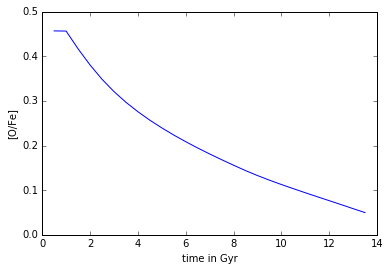

In [8]:
## Alpha enhancement over time

plot(cube.cube['time'][1:],abundances['O'][1:]-abundances['Fe'][1:])
plt.xlabel('time in Gyr')
plt.ylabel('[O/Fe]')

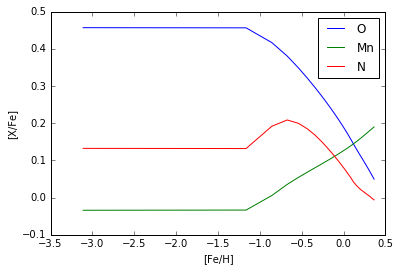

In [9]:
# [X/Fe] vs. [Fe/H]

plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], label = 'O')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], label = 'Mn')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], label = 'N')
plt.xlabel('[Fe/H]')
plt.ylabel('[X/Fe]')
plt.legend()

## Likelihood calculation
There are a few build-in functions (actually representing the observational constraints from the Chempy paper) which return a likelihood. One of those is called sol_norm and compares the proto-solar abundances with the Chempy ISM abundances 4.5 Gyr ago.

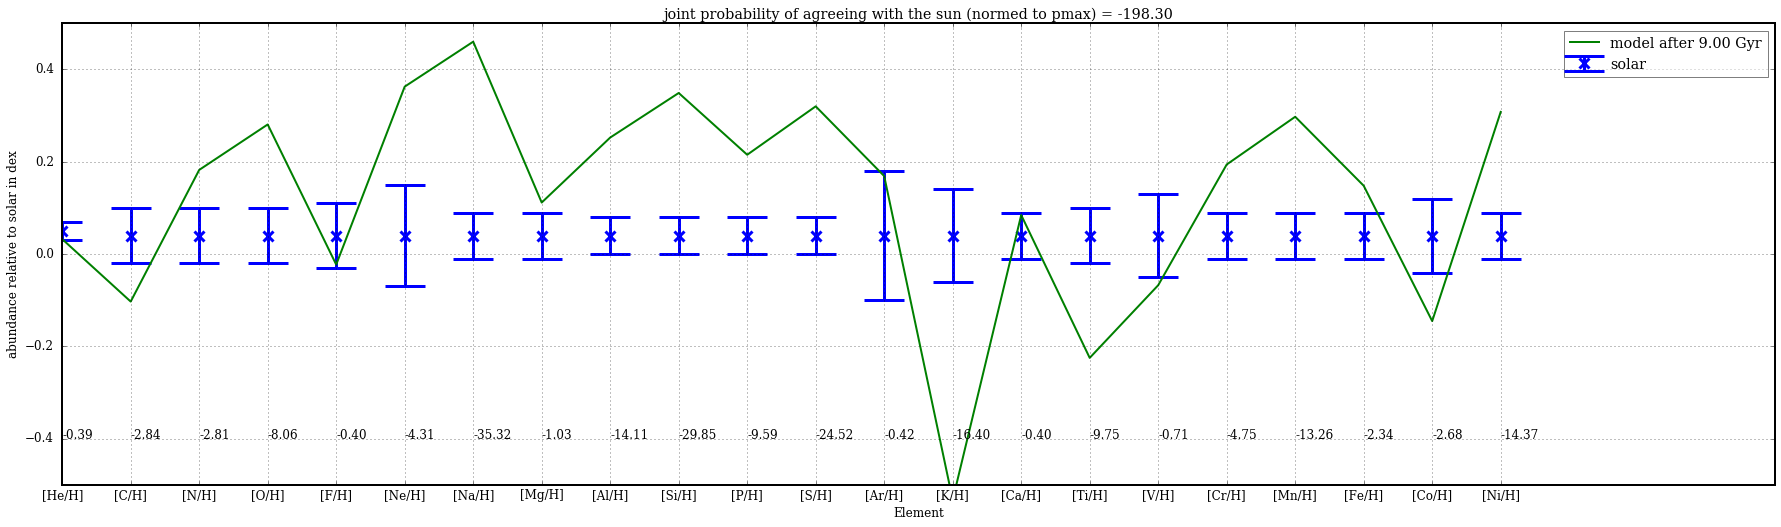

In [10]:
# Here we load a likelihood test for the solar abundances
# This is how it looks for the prior parameters with the default yield set

from Chempy.data_to_test import sol_norm
probabilities, abundance_list, element_names = sol_norm(True,a.name_string,np.copy(abundances),np.copy(cube.cube),elements_to_trace,a.element_names,np.copy(basic_solar.table),a.number_of_models_overplotted,a.produce_mock_data,a.use_mock_data,a.error_inflation)

## Net vs. total yield
Now we will change a little detail in the time-integration. Instead of letting unprocessed material that is expelled from the stars ('unprocessed_mass_in_winds' in the yield tables) being composed of the stellar birth material, which would be consistent (and is what I call 'net' yield), we now use solar-scaled material which only has the same metallicity as the stellar birth material (This is what happens if yield tables are giving the total yield including the unprocessed material, which means that the author usually uses solar-scaled material which is then expelled by the star, but might not even be produced by it). Therefore we see a difference in the likelihood which is better for the total yields case (-180.05 vs -198.30). We see the difference especially well in K and Ti.

/home/jan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


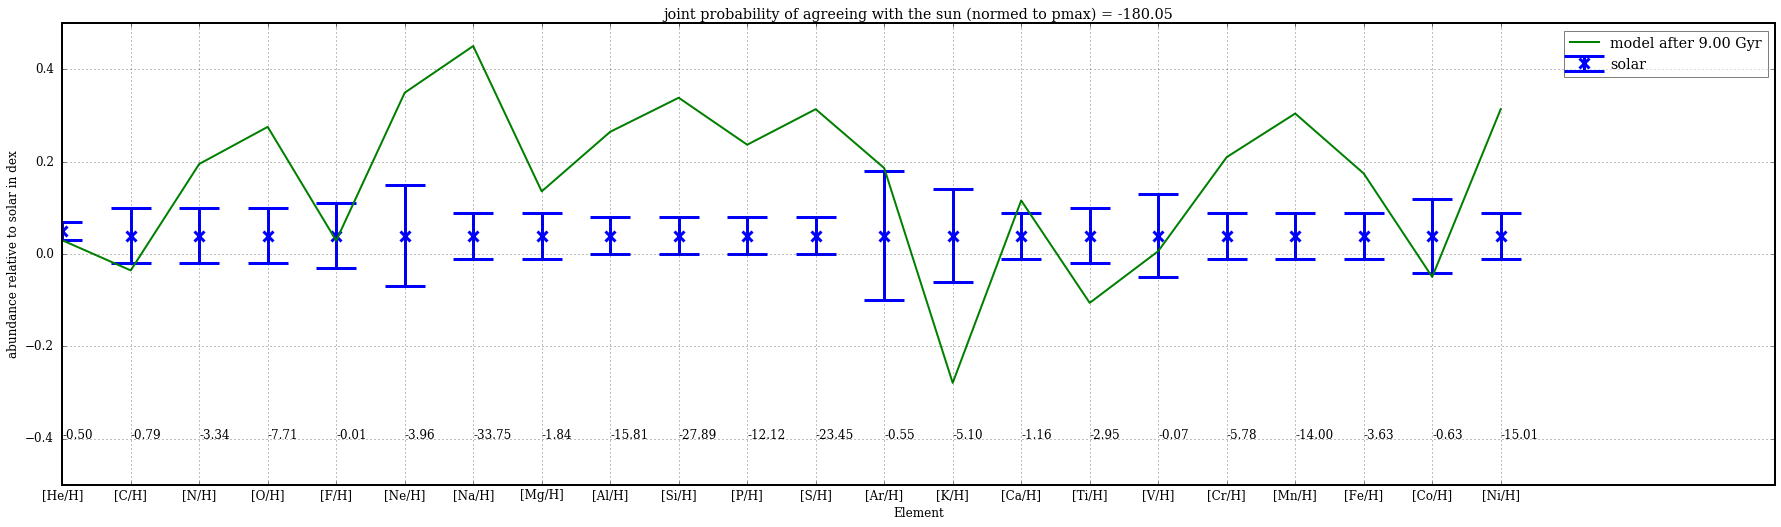

In [11]:
cube = ABUNDANCE_MATRIX(np.copy(basic_sfr.t),np.copy(basic_sfr.sfr),np.copy(basic_infall.infall),list(elements_to_trace),list(basic_primordial.symbols),list(basic_primordial.fractions),float(a.gas_at_start),list(basic_primordial.symbols),list(basic_primordial.fractions),float(a.gas_reservoir_mass_factor),float(a.outflow_feedback_fraction),bool(a.check_processes),float(a.starformation_efficiency),float(a.gas_power), float(a.sfr_factor_for_cosmic_accretion), list(basic_primordial.symbols), list(basic_primordial.fractions))
basic_ssp = SSP_wrap(a)
for i in range(len(basic_sfr.t)-1):
    j = len(basic_sfr.t)-i
    metallicity = float(cube.cube['Z'][i])
    
    # Instead of using the ISM composition we use solar scaled material
    
    solar_scaled_material = PRIMORDIAL_INFALL(list(elements_to_trace),np.copy(basic_solar.table))
    solar_scaled_material.solar(np.log10(metallicity/basic_solar.z))
    time_steps = np.copy(basic_sfr.t[:j])
    basic_ssp.calculate_feedback(float(metallicity), list(elements_to_trace), list(solar_scaled_material.fractions), np.copy(time_steps))
    cube.advance_one_step(i+1,np.copy(basic_ssp.table),np.copy(basic_ssp.sn2_table),np.copy(basic_ssp.agb_table),np.copy(basic_ssp.sn1a_table))
abundances,elements,numbers = mass_fraction_to_abundances(np.copy(cube.cube),np.copy(basic_solar.table))


# We do the solar abundance test again and see that the likelihood improves

probabilities, abundance_list, element_names = sol_norm(True,a.name_string,np.copy(abundances),np.copy(cube.cube),elements_to_trace,a.element_names,np.copy(basic_solar.table),a.number_of_models_overplotted,a.produce_mock_data,a.use_mock_data,a.error_inflation)

## Making chemical evolution modelling fast and flexible
Now we have all ingredients at hand. We use a wrapper function were we only need to pass the ModelParameters.

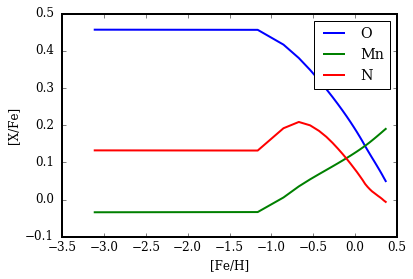

In [12]:
# This is a convenience function 

from Chempy.wrapper import Chempy
a = ModelParameters()
cube, abundances = Chempy(a)
plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], label = 'O')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], label = 'Mn')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], label = 'N')
plt.xlabel('[Fe/H]')
plt.ylabel('[X/Fe]')
plt.legend()

## IMF effect
now we can easily check the effect of the IMF on the chemical evolution

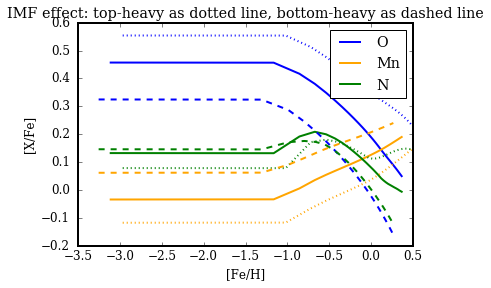

In [13]:
# prior IMF

a = ModelParameters()
a.imf_parameter= (22.8978, 716.4, 0.25,-2.29)
cube, abundances = Chempy(a)

plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], label = 'O', color = 'b')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], label = 'Mn', color = 'orange')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], label = 'N', color = 'g')


# top-heavy IMF

a = ModelParameters()
a.imf_parameter = (22.8978, 716.4, 0.25,-2.09)
cube, abundances = Chempy(a)

plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], color = 'b', linestyle = ':')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], color = 'orange', linestyle = ':')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], color = 'g', linestyle = ':')

# bottom-heavy IMF

a = ModelParameters()
a.imf_parameter = (22.8978, 716.4, 0.25,-2.49)
cube, abundances = Chempy(a)

plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], color = 'b', linestyle = '--')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], color = 'orange', linestyle = '--')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], color = 'g', linestyle = '--')


plt.xlabel('[Fe/H]')
plt.ylabel('[X/Fe]')
plt.title('IMF effect: top-heavy as dotted line, bottom-heavy as dashed line')
plt.legend()

## SFR effect
We can do the same for the peak of the SFR etc...

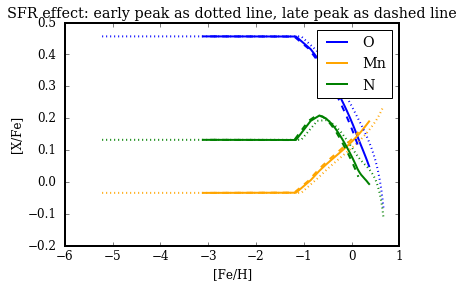

In [14]:
# Prior SFR

a = ModelParameters()
a.sfr_scale = 3.5
cube, abundances = Chempy(a)

plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], label = 'O', color = 'b')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], label = 'Mn', color = 'orange')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], label = 'N', color = 'g')


# Early peak in the SFR

a = ModelParameters()
a.sfr_scale = 1.5
cube, abundances = Chempy(a)

plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], color = 'b', linestyle = ':')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], color = 'orange', linestyle = ':')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], color = 'green', linestyle = ':')


# late peak in the SFR

a = ModelParameters()
a.sfr_scale = 6.5
cube, abundances = Chempy(a)

plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], color = 'b', linestyle = '--')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], color = 'orange', linestyle = '--')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], color = 'green', linestyle = '--')


plt.xlabel('[Fe/H]')
plt.ylabel('[X/Fe]')
plt.title('SFR effect: early peak as dotted line, late peak as dashed line')
plt.legend()

## Time resolution
The time steps are equidistant and the resolution is flexible. Even with coarse 0.5Gyr resolution the results are quite good, saving a lot of computational time. Here we test different time resolution of 0.5, 0.1 and 0.025 Gyr.

All results converge after metallicity increases above -1. The shorter time sampling allows more massive stars to explode first which generally have alpha enhanced yields, therefore the [O/Fe] is higher in the beginning.

/home/jan/anaconda2/lib/python2.7/site-packages/Chempy-0.1-py2.7.egg/Chempy/making_abundances.py:49: RuntimeWarning: invalid value encountered in log10
  cube_abundances[item] = np.where(cube_abundances[item] == 0. , -np.inf, np.log10(cube_abundances[item]) + 12.)


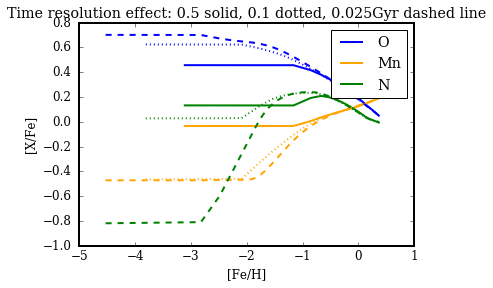

In [15]:
## 0.5 Gyr resolution

a = ModelParameters()
a.time_steps = 28 # default
cube, abundances = Chempy(a)

plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], label = 'O', color = 'b')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], label = 'Mn', color = 'orange')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], label = 'N', color = 'g')


# 0.1 Gyr resolution

a = ModelParameters()
a.time_steps = 136
cube, abundances = Chempy(a)

plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], color = 'b', linestyle = ':')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], color = 'orange', linestyle = ':')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], color = 'green', linestyle = ':')


# 25 Myr resolution

a = ModelParameters()
a.time_steps = 541
cube, abundances = Chempy(a)

plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], color = 'b', linestyle = '--')
plot(abundances['Fe'][1:],abundances['Mn'][1:]-abundances['Fe'][1:], color = 'orange', linestyle = '--')
plot(abundances['Fe'][1:],abundances['N'][1:]-abundances['Fe'][1:], color = 'green', linestyle = '--')


plt.xlabel('[Fe/H]')
plt.ylabel('[X/Fe]')
plt.title('Time resolution effect: 0.5 solid, 0.1 dotted, 0.025Gyr dashed line')
plt.legend()

# A note on chemical evolution tracks and 'by eye' fit
Sometimes Astronomers like to show that their chemical evolution track runs through some stellar abundance data points. But if we want the computer to steer our result fit we need to know the selection function of the stars that we try to match and we need to take our star formation history into account (Maybe there are almost no stars formed after 8Gyr).
- We assume that we have an unbiased sample of red clump stars
- We reproduce its selection function by multiplying their age-distribution for a flat SFR with the SFR.
(for the age distribution I have included a cut from a mock catalogue according to [Just&Rybizki 2016](http://adsabs.harvard.edu/abs/2016AN....337..880J) but you could also use the analytic formula from [Bovy+2014](http://adsabs.harvard.edu/abs/2014ApJ...790..127B))
- Then we sample some synthetic stars (with observational errors) along the chemical evolutionary track

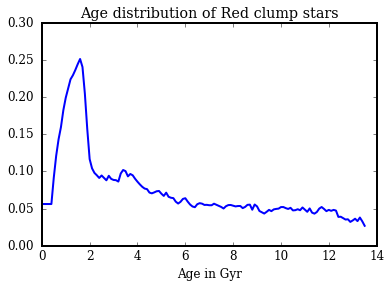

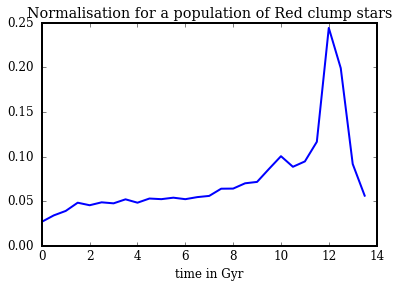

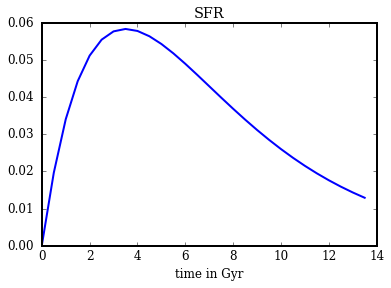

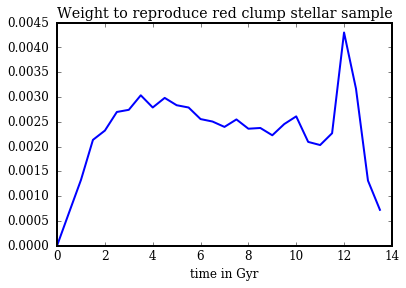

In [16]:
# Default model parameters
from Chempy import localpath

a = ModelParameters()
cube, abundances = Chempy(a)


# Red clump age distribution

selection = np.load(localpath + "input/selection/red_clump_new.npy")
time_selection = np.load(localpath + "input/selection/time_red_clump_new.npy")

plt.plot(time_selection,selection)
plt.xlabel('Age in Gyr')
plt.title('Age distribution of Red clump stars')
plt.show()


# We need to put the age distribution on the same time-steps as our model

selection = np.interp(cube.cube['time'], time_selection[::-1], selection)
plt.plot(cube.cube['time'],selection)
plt.xlabel('time in Gyr')
plt.title('Normalisation for a population of Red clump stars')
plt.show()


# Comparing to the SFR

plt.plot(cube.cube['time'],cube.cube['sfr'])
plt.xlabel('time in Gyr')
plt.title('SFR')
plt.show()


# Convolution of SFR and Red clump age distribution

weight = cube.cube['sfr']*selection
plt.plot(cube.cube['time'],weight)
plt.xlabel('time in Gyr')
plt.title('Weight to reproduce red clump stellar sample')
plt.show()

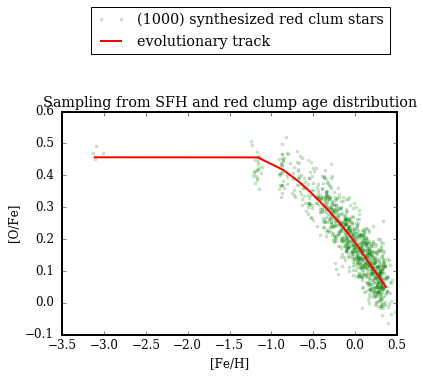

In [17]:
# Here we sample 1000 stars with this age-distribution

from Chempy.data_to_test import sample_stars
sample_size = 1000
x,y = sample_stars(cube.cube['sfr'][1:],selection[1:],abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:],float(basic_solar.table['error'][np.where(basic_solar.table['Symbol']=='Fe')]),float(basic_solar.table['error'][np.where(basic_solar.table['Symbol']=='O')]),int(sample_size))
plt.plot(x,y,"g.", alpha = 0.2, label = '(%d) synthesized red clum stars' %(int(sample_size)))
plt.plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:], 'r', label = 'evolutionary track')
plt.xlabel('[Fe/H]')
plt.ylabel('[O/Fe]')
plt.title("Sampling from SFH and red clump age distribution")
plt.legend(bbox_to_anchor = [1,1.5])
plt.show()

<function matplotlib.pyplot.show>

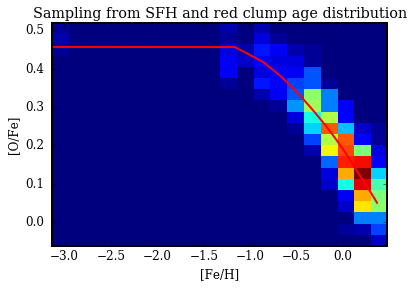

In [18]:
# And we plot the 2d histogramm where we see that our model prediction for a red clump population


plt.hist2d(x,y,20)
plt.plot(abundances['Fe'][1:],abundances['O'][1:]-abundances['Fe'][1:],'r')
plt.xlabel('[Fe/H]')
plt.ylabel('[O/Fe]')
plt.title("Sampling from SFH and red clump age distribution")
plt.show


This PDF can then be compared to real data to get a realistic likelihood.

## The nucleosynthetic feedback per element
With the plot_processes routine we can plot the total feedback of each element and the fractional contribution from each nucleosynthetic feedback for a specific Chempy run.

[0]

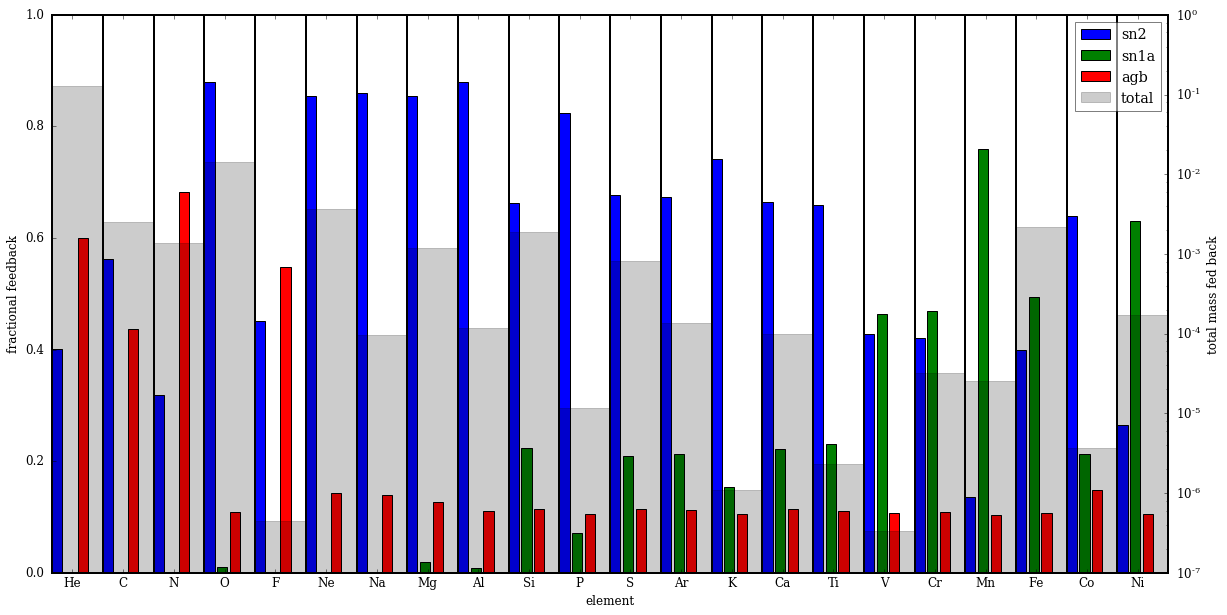

In [19]:
# Loading the routine and plotting the process contribution into the current folder
# Total enrichment mass in gray to the right, single process fractional contribution to the left

from Chempy.data_to_test import plot_processes
plot_processes(True,a.name_string,cube.sn2_cube,cube.sn1a_cube,cube.agb_cube,a.element_names,np.copy(cube),a.number_of_models_overplotted)